# Basics of Precise Radial Velocities, and Performing CCF

Created by Sharon Xuesong Wang, August 9, 2019
Written by Sharon Xuesong Wang and Tianjun Gan

This is a tutorial for getting to know the basics of precise radial velocities, such as how to get RV using the CCF method, the correlation of RV precision vs. resolution and SNR, and so on.

In [1]:
# import the necessary packages
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as gridspec
from scipy import interpolate
from scipy.optimize import fmin
import emcee
import corner
%matplotlib inline 

## Doppler Shifting a Spectrum

Let's start with getting a 5 Angstrom chunk of synthetic solar spectrum, which is about the length of a spectral order, and manipulate it to get ourselves familiar with Doppler-shifting a spectrum.

Read in the synthetic solar spectrum here:

In [2]:
os.chdir('../synspec')
specdata=np.load('Kurucz_Sun.npz')
wavelength=specdata['arr_0']
flux=specdata['arr_1']

Grab a chunk between 5200 and 5205 Angstroms, which is the richest region in terms of Doppler information in the Sun.

We will come back to the point of "Doppler information" later.

In [3]:
w_chunk=wavelength[(wavelength>=520) & (wavelength<=520.5)]
f=flux[(wavelength>=520) & (wavelength<=520.5)]

Now, Doppler shift this chunk of spectrum by 27201 m/s.

**Convention of Doppler Shift**: This is a positive number, which means the source is redshifted relative to the observatory frame. The convention is that a blueshift, or object moving towards the observer, will have a negative redshift (thus negative RV).

Why such a large number? The Earth is going around the Sun at ~30 km/s, so any stellar spectrum you see will have
a relative Doppler shift from this motion from its spectrum taken at another epoch. This is called the barycentric (BC) shift. For stars near the celestial equator, for example, the BC shift will swing a full span of from -30 km/s to 30 km/s over the course of a year.

Important points when you are doing a Doppler shift:

- Don't forget to define the speed of light! And do it very very precisely! Do not use $3 \times 10^8$ m/s.
- A Doppler shift is not linear in wavelength space - you do not add a number. It's like a stretch. You stretch the wavelength array $w$ by doing $w\times (1+z)$.

In [4]:
c=2.99792458E8 #light speed in m/s
v_rad=27201    #m/s
z=v_rad/c
z_correct=z
w_observed=w_chunk*(1+z)

Plot the original spectrum and the shifted one next to each other.

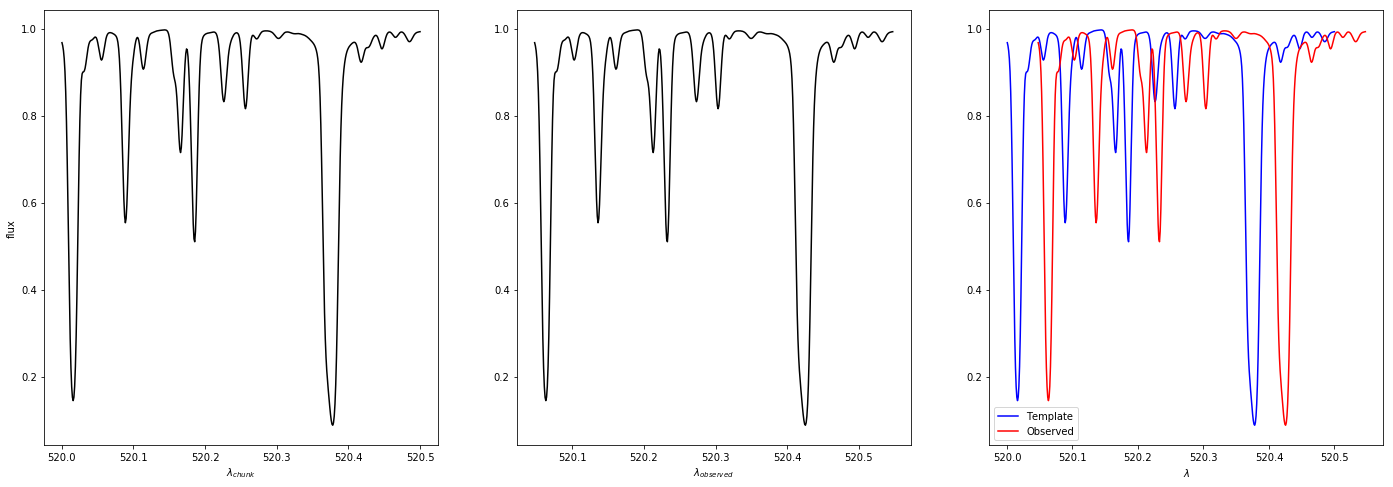

In [5]:
fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax1.plot(w_chunk,f,'k-')
ax2.plot(w_observed, f,'k-')
ax3.plot(w_chunk,f,'b-')
ax3.plot(w_observed, f,'r-')
ax3.legend(['Template','Observed'])
ax1.set_xlabel('$\lambda_{chunk}$')
ax2.set_xlabel('$\lambda_{observed}$')
ax3.set_xlabel('$\lambda$')
ax1.set_ylabel('flux')
plt.show()

## Simplest CCF

Now, the shifted spectrum is your "observed" spectrum. Our next task would be to try to get the RV of this observed spectrum with CCF using the "stellar template", which is the original spectrum before the shift (note: this stellar template has a wider wavelength span than your order of shifted spectrum, so we don't have to worry about edge effects). 

Note: Some people use a mask instead of a stellar template (Baranne et al. 1996) then fit a Gaussian to the CCF - it's mathematically equivalent with using a spectrum (with a Gaussian line profile) to perform the CCF and obtain the minima/maxima of the CCF (credit: David Hogg).

Our eventual goal is to obtain the CCF as a function of redshift $z$, and then find the minima of the CCF, which would be your reported $z$. **Important**: You have to fit the redsfhit $z$ instead of the RV! This is because **$z$ is what you are actually measuring, not the relative RV** between your stellar template and your observed template. To translate $z$ into RV, you need to perform the barycentric correction, which involves relativistic terms so a simple $z = RV/c$ does not work.

The first thing is to create an array of $z$ values. Think carefully about what min and max values should you give this array of $z$ when it comes to real observations.

In [12]:
#For z, at first I chose -(3E4)/c ~ (3E4)/c only consider about the BC shift
z_max=(3E4)/c
z_min=(-3E4)/c
print(z_max)
print(z_min)
z_list=np.linspace(z_min,z_max,100)

0.000100069228559
-0.000100069228559


Next, for each $z$ value, you would need to shift your stellar template spectrum to this $z$, and then you want to interpolate your spectrum so that it is evaluated at the same array of wavelenghs as your observed spectrum in order to perform CCF (i.e., same abscissa). Write a function to perform this shift and interpolation.

Make sure to use cubic spline interpolation, not linear.

In fact, neither cubic spline nor linear interpolation conserves flux and therefore Doppler shift. At the sampling rate of our synthetic spectrum, cubic spline does a good enough job that we can ignore this. Very often, when you are working with spectrum with relatively low sampling, you want to up-sample your spectrum first before doing interpolation. Let's don't worry about it right now.

In [7]:
def spec_interpolation(z,w1,flux,w2):   #w1:template wavelength, w2:predicted wavelength
    w1_correction=w1*(1+z)
    f = interpolate.interp1d(w1_correction,flux,kind='cubic')
    #f = interpolate.interp1d(w1_correction,flux)
    flux_pred = f(w2)
    return flux_pred

Check your shift+interpolation function out by plotting a zoomed in chunk of spectrum before and after the operation.

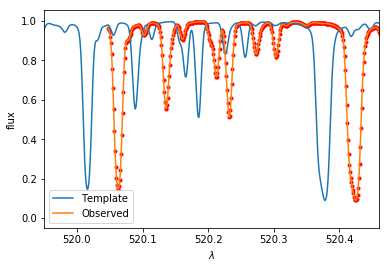

In [8]:
#Example#
z_example= 9E-5
w_template=wavelength[(wavelength>519.8) & (wavelength<520.6)]
f_template=flux[(wavelength>519.8) & (wavelength<520.6)]
#print(w_template)
#print(w_emitted)
#exit()
flux_pred = spec_interpolation(z_example,w_template,f_template,w_observed)
plt.figure()
plt.plot(wavelength,flux)
plt.plot(w_observed,flux_pred)
plt.legend(['Template','Observed'])
plt.scatter(w_observed,flux_pred,color='red',marker='.')
plt.xlim(519.95,520.46)
plt.xlabel('$\lambda$')
plt.ylabel('flux')
plt.show()

Now, write a loop to evaluate the CCF at every $z$ value in your $z$ array.

**Important Caution**: Some people like to use the simpler version of CCF, which is $\sum{s*f}$, where $s$ and $f$ are the two functions you are performing CCF on. However, this is wrong in our context. The formal CCF is really $\sum{(s-f)^2}$, and when you have a constant $\sum{s^2}$ and $\sum{f^2}$, you can just use the cross term. However, this is not true in our case! When we are shifting the stellar template spectrum around within the wavelength window of the observed spectrum, on the edge, some portion will be shifted in and out. So your template spectrum $s$ actually changes every time you use a different $z$, so $\sum{s^2}$ is not constant! 

In [13]:
ccf_list=[]
for z in z_list:
    CCF = np.sum((spec_interpolation(z,w_template,f_template,w_observed)-f)**2)
    ccf_list=np.append(ccf_list,[CCF],axis=0)
    print(CCF)
print(ccf_list)

46.23863178139102
45.21782566909003
44.26306001574814
43.39082571632418
42.61230462869337
41.934192907535206
41.359411885903626
40.887130400301274
40.5115839623086
40.21926052367132
39.98691715265784
39.77948590994007
39.55333639648471
39.26353021104203
38.87457179772798
38.36856893885523
37.747977162559586
37.032729413303656
36.255287631519586
35.45577025744245
34.6778093104809
33.96493900497003
33.357511016411024
32.890081351777795
32.58952123304281
32.47361710612478
32.55002369766855
32.81558229144305
33.25598203271454
33.84621831301897
34.552025201753544
35.332633479658824
36.14446974163925
36.94552077020202
37.69941315836745
38.37861158985727
38.965970745710756
39.454663649707825
39.846535315190756
40.14941743577026
40.374121644840486
40.53178360070453
40.63204094667704
40.68230119206903
40.68785464529776
40.65256768890548
40.5796453221767
40.47250076875089
40.33558255761595
40.17499095836888
39.998750896996896
39.81657225471022
39.63901103612961
39.47623147967292
39.3365913973318

Plot your CCF vs. z.

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax1.plot(z_list,ccf_list)
ax2.plot(z_list[(z_list<10E-5) & (z_list>0)],ccf_list[(z_list<10E-5) & (z_list>0)])
plt.show()

Write a function to find the minima of your CCF robustly.

Optimization terminated successfully.
         Current function value: 135.241718
         Iterations: 183
         Function evaluations: 308
[9.26342364e-05 2.61539808e-05 3.79420889e+01 3.89700819e+01]


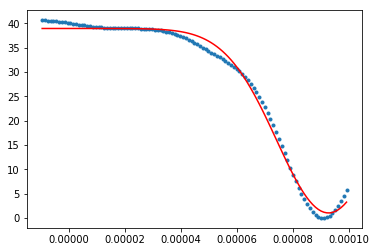

In [12]:
z_chosen=z_list[(z_list<10E-5) & (z_list>-1E-5)]
ccf_chosen=ccf_list[(z_list<10E-5) & (z_list>-1E-5)]

#fmin#

def ccf_fit(z,p):
    u,sigma,c,k = p
    return k-c*np.exp(-(z-u)**2/(sigma**2))

def residuals(p,z,f):
    return np.sum((f-ccf_fit(z,p))**2)

iniparam0=[9E-5,1E-5,10,40]
parambest,chi2min,iter,funcalls,warnflag,allvecs = fmin(residuals,iniparam0,args=(z_chosen,ccf_chosen),full_output=True,retall=True,maxiter=300,maxfun=1000)
print(parambest)

plt.figure()
plt.plot(z_chosen,ccf_chosen,'.')
plt.plot(z_chosen,ccf_fit(z_chosen,parambest),'r-')
plt.show()

Now you have a measured z! Is it correct?

In [9]:
#fitting result#
print ("z_fitted=%s"%(parambest[0]))
print ("z_correct=%s"%(z_correct))

NameError: name 'parambest' is not defined